Up to date version of this document is available at https://github.com/zlcc9/dmhr

## Assignment A

### Introduction
This analysis will use datasets from NHS Digital for the month of April 2018 available 
<a href='https://digital.nhs.uk/data-and-information/publications/statistical/practice-level-prescribing-data/april-2018'>here</a> and <a href='https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice/patients-registered-at-a-gp-practice-april-2018-special-topic---registered-patients-compared-to-the-projected-resident-population-in-england'>here.</a>
<p> I will be using Pandas and other standard modules to analysis the data</p>

In [771]:
#preliminaries
import pandas as pd
import re
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plot
%matplotlib inline

I will first explore the datasets that are available.  There are three datasets which I shall use (I have downloaded these files and saved them locally):
#### 1. Patients Registered at a GP Practice

In [494]:
# Try importing a local file, if not, download and import
try:
    registrations_df = pd.read_csv('gp-reg-pat-prac-all.csv', index_col= False)
except FileNotFoundError:
    registrations_df = pd.read_csv('https://files.digital.nhs.uk/71/B59D99/gp-reg-pat-prac-all.csv', index_col= False)
registrations_df.head()

,PUBLICATION,EXTRACT_DATE,TYPE,CCG_CODE,ONS_CCG_CODE,CODE,POSTCODE,SEX,AGE,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83005,DL1 3RT,ALL,ALL,11826
1,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83006,DL3 6HZ,ALL,ALL,8044
2,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83010,DL3 9JP,ALL,ALL,14070
3,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83013,DL1 4YL,ALL,ALL,11298
4,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83031,DL3 8SQ,ALL,ALL,10109


The key information in this data set is the GP practice code (identified by CODE) and the number patients registered on the 1st April 2018.  Postcode may also be useful.  Information here is for all patients; separate data sets are avaialble for break down by age (both single year of age and 5-year age bands, both of which finish at 95+) and by gender, if required.

I will change the column names to standardize them with other data sets

In [820]:
#rename columns with lower case indexes.  rename code to practice_code
registrations_df.columns = registrations_df.columns.str.lower()
registrations_df.rename(columns={'code':'practice_code'},inplace = True)
registrations_df.head()

,publication,extract_date,type,ccg_code,ons_ccg_code,practice_code,postcode,sex,age,number_of_patients
0,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83005,DL1 3RT,ALL,ALL,11826
1,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83006,DL3 6HZ,ALL,ALL,8044
2,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83010,DL3 9JP,ALL,ALL,14070
3,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83013,DL1 4YL,ALL,ALL,11298
4,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83031,DL3 8SQ,ALL,ALL,10109


In [524]:
#count the number of rows
registrations_df.shape

(7241, 10)

There is information for number of patients on 7241 Practices in England.

#### 2. Practice Prescribing Data
This is a very large file (1.4 GB) which contains information on all medicines, dressings and appliances prescribed by all practices in England and dispensed in the community in April 2018.

In [502]:
#set file and column names to import NHS Digital GP Practice Prescribing dataset
path = 'http://datagov.ic.nhs.uk/presentation/2018_04_April/'
prescribing_file = 'T201804PDPI+BNFT.CSV'
prescribing_cols = ['sha', 'pct', 'practice_code', 'bnf_code', 'bnf_name', 'items', 'nic', 'act_cost', 'quantity', 'period']

#try importing local file, if not, download and import
try:
    prescribing_df = pd.read_csv(prescribing_file, names=prescribing_cols, skiprows=1, index_col= False)
except FileNotFoundError:
    prescribing_df = pd.read_csv(path + prescribing_file, names=prescribing_cols, skiprows=1, index_col= False)
prescribing_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
0,Q44,RTV,Y04937,0401010Z0AAAAAA,Zopiclone_Tab 7.5mg,6,1.56,2.12,63,201804
1,Q44,RTV,Y04937,0401020K0AAAHAH,Diazepam_Tab 2mg,4,0.87,1.15,73,201804
2,Q44,RTV,Y04937,0401020K0AAAIAI,Diazepam_Tab 5mg,2,0.46,0.56,35,201804
3,Q44,RTV,Y04937,0402010ABAAABAB,Quetiapine_Tab 25mg,1,2.60,2.52,14,201804
4,Q44,RTV,Y04937,0402010ADAAAAAA,Aripiprazole_Tab 10mg,1,1.53,1.53,14,201804


A detailed glossary of terms can be found on the NHS website above.  Here I have given a summary of the data fields:
- sha: code of the Strategic Health Authority in which the practice resides
- pct: code of the Primary Care Trust in which the practice resides
- practice code:  this is the GP practice code which can be used to linked to other data
- bnf_code: BNF code for each drug (characters 1 and 2 show the BNF chapter,3 and 4 show the BNF section)
- bnf_name:  individual preparation name, which may be proprietary or generic, followed by form and strength
- items: the number of items for this presentation that were dispensed in April. ie number of prescriptions
- nic: Net ingredient cost. This is the basic cost of a drug (list price excluding VAT)
- act_cost: the actual cost charged back to practices from all dispensed prescriptions
- quantity: The quantity of a drug dispensed for all prescriptions (measured in units depending on the formulation of the product: a number for tablets, capsules, ampoules, vials etc; millilitres for liquids; grams for solids (such as cream, gel, ointment))
- period: This period is April 2018

<p>The prescription processing activity is internally audited to 97.5% accuracy (meaning at least 97.5% of prescriptions are recorded accurately)</p>

In [821]:
#Strip white space from data in all columns of type object (ie strings)
for column in prescribing_df.columns:
    if prescribing_df[column].dtype == 'object':
        prescribing_df[column] = prescribing_df[column].str.strip()

#### 3. Practice codes, names and addresses

In [504]:
#Import the NHS Digital 'GP Practice codes, names and addresses' dataset
#set file name and column names to import
practice_file = 'T201804ADDR+BNFT.CSV'
practice_cols = ['time_period', 'practice_code', 'practice_name', 'practice_organization', 'street', 'city', 
    'area', 'postcode']

#try importing local file, if not, download and import
try:
    practice_df = pd.read_csv(practice_file, header=None, names=practice_cols, index_col=False)
except FileNotFoundError:
    practice_df = pd.read_csv(url + practice_file, header=None, names=practice_cols, index_col=False)
practice_df.head()

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
0,201804,A81001,THE DENSHAM SURGERY,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 1HU
1,201804,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
2,201804,A81004,BLUEBELL MEDICAL CENTRE,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,TS5 8SB
3,201804,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,TS14 7DJ
4,201804,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MEDICAL PRACT,TENNANT STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 2AT


This data set contains the name and address for each practice in England.  It links to the other data sets with the 'practice_code' field.
There are some missing and misplaced values.  Where a practice does not supply a practice name the first line of the address is used. The file is arranged so the final column is usually the postcode even if this requires other parts of the address to be repeated or left blank to achieve this.  For example, the row at index 2: Bluebell Medical Centre has no area, and the street is recorded as 'Acklam' which is a town.

Additionally, the strings in some columns are formatted with extra white space:

In [506]:
#inspect a sample string
practice_df['city'][50]

'HARTLEPOOL               '

This data set needs cleaning to remove the white space from these columns (I also did this with the prescribing_df):

In [520]:
#Strip white space from data in all columns of type object (ie strings), standardize case
for column in practice_df.columns:
    if practice_df[column].dtype == 'object':
        practice_df[column] = practice_df[column].str.strip()
        if practice_df[column].name == 'postcode':
            practice_df[column] = practice_df[column].str.upper()
        else:
            practice_df[column] = practice_df[column].str.title()
practice_df.head()

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
0,201804,A81001,The Densham Surgery,The Health Centre,Lawson Street,Stockton-On-Tees,Cleveland,TS18 1HU
1,201804,A81002,Queens Park Medical Centre,Queens Park Medical Ctr,Farrer Street,Stockton On Tees,Cleveland,TS18 2AW
2,201804,A81004,Bluebell Medical Centre,Trimdon Avenue,Acklam,Middlesbrough,,TS5 8SB
3,201804,A81005,Springwood Surgery,Springwood Surgery,Rectory Lane,Guisborough,,TS14 7DJ
4,201804,A81006,Tennant Street Medical Practice,Tennant St Medical Pract,Tennant Street,Stockton-On-Tees,Cleveland,TS18 2AT


In [529]:
practice_df.shape

(9578, 8)

There are over 2000 more practices in the address dataset than there are practices in the registration dataset. I have looked up the practices with missing demographic information. Some of these are not GP practices, they are emergency care centres.  Other practicess, for example <a href='http://www.linthorpesurgery.com/'>"Oakfield Medical Practice'</a> have multiple sites, so they have several practice codes, but patients are only registered to one practice.  Although I can't check all 2000 practices individually, this exploration reassures me that the registration information is correct and I do not need to worry about this 'missing' information.

In [555]:
#Find practices which have an address but no patient registration information
missing_practices = practice_df[~(practice_df['practice_code'].isin(registrations_df['practice_code']))]
missing_practices.head()

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
27,201804,A81033,Oakfield Medical Practice,378 Linthorpe Road,,Middlesbrough,Cleveland,TS5 6HA
354,201804,A89014,Drs Gellia & Balaraman,Monkwearmouth Hth Ctr,Dundas Street,Sunderland,Tyne & Wear,SR6 0AB
369,201804,A89029,Springwell House,3 Swiss Cottages,Vigo Lane,Washington,Tyne & Wear,NE38 9AB
625,201804,B83069,Picton At Whetley Medical Centre,Whetley Medical Centre,2 Saplin Street,Bradford,West Yorkshire,BD8 9DW
626,201804,B83070,Mughal Medical Centre,Kensington Street Hth.Ctr,Whitefield Place,Bradford,West Yorkshire,BD8 9LB


In [556]:
# Explore to see if other practices have patients registered at the same address as Oakfield Medical Practice
registrations_df[registrations_df['postcode']=='TS5 6HA']

,publication,extract_date,type,ccg_code,ons_ccg_code,practice_code,postcode,sex,age,number_of_patients
169,GP_PRAC_PAT_LIST,01APR2018,GP,00M,E38000162,A81026,TS5 6HA,ALL,ALL,18438


In [557]:
#Find addres information on the practice found at the same address
practice_df[practice_df['practice_code']=='A81026']

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
21,201804,A81026,The Linthorpe Surgery,378 Linthorpe Road,,Middlesbrough,Cleveland,TS5 6HA


### Question 1

To identify all GP practices located in London, I will use the Practice Code, Name and Address dataset.  Since I know that there is some variation in this dataset from earlier exploration, I will search for London recorded in 'city', 'area' and 'street'.

In [570]:
#Create a subset of the practice_df for london practices
london_practice_df = practice_df[(practice_df['city']=="London")|(practice_df['area']=="London")|(practice_df['street']=="London")]
london_practice_df.shape

(930, 8)

In [571]:
#Create a subset of the registrations_df where practice_code is in london
london_registrations_df = registrations_df[registrations_df['practice_code'].isin(london_practice_df['practice_code'])]
london_registrations_df.shape

(747, 10)

In [572]:
#Calculate total number of patients registered in London
num_london_registrations = london_registrations_df['number_of_patients'].sum()
num_london_registrations

5841956

I have identified 930 practices in London, of which 747 have patients registered.  There are 5,841,956 patients registered in total.  Next I will look at the number of prescriptions in london:

In [585]:
# Create a subset of the prescribing_df for london practices
london_prescribing_df = prescribing_df[prescribing_df['practice_code'].isin(london_practice_df['practice_code'])]
london_prescribing_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
5336654,Q58,06N,Y04681,0101021B0BEADAJ,Gaviscon Infant_Sach 2g (Dual Pack) S/F,1,4.82,4.48,15,201804
5336655,Q58,06N,Y04681,0106040M0BBAAAA,Movicol_Pdr Sach 13.8g (Lem & Lim),1,5.41,5.13,20,201804
5336656,Q58,06N,Y04681,0106040M0BBAJAB,Movicol_Paed Pdr Sach 6.9g (Choc),1,4.38,4.07,30,201804
5336657,Q58,06N,Y04681,0106040N0AAABAB,Phos Enem_(For B) 128ml Stnd Tube,1,39.80,36.92,10,201804
5336658,Q58,06N,Y04681,0106040R0BBAAAF,Micralax_Micro-Enem 5ml,1,4.06,3.88,10,201804


In [576]:
#Add up all the prescriptions (ie. items)
num_london_prescriptions = london_prescribing_df['items'].sum()
num_london_prescriptions

5881715

In [579]:
#Add up the actual cost of all these prescriptions
act_cost_london = london_prescribing_df['act_cost'].sum()
act_cost_london

43326121.52

5,881,715 prescriptions have been dispesed in London in April 2018, with an actual cost of £43,326,121.52

I will now calculate the most frequently prescribed medicines across all London practices.  I have chosen to group by 'bnf_name' as some drugs appear in multiple sections of the BNF.

In [815]:
# Create a dataframe just with columns of interest
london_totals = london_prescribing_df[['bnf_name','items','act_cost']]

# Calculate total items
london_totals = london_totals.groupby(['bnf_name']).sum().reset_index()

#sort by total items
london_totals = london_totals.sort_values(by='items',ascending=False)
london_totals.head(10)

,bnf_name,items,act_cost
8329,Omeprazole_Cap E/C 20mg,123312,98763.40
7411,Metformin HCl_Tab 500mg,121065,353103.89
654,Amlodipine_Tab 5mg,103369,181903.01
922,Atorvastatin_Tab 20mg,100067,90920.31
653,Amlodipine_Tab 10mg,95714,178897.43
924,Atorvastatin_Tab 40mg,91246,92597.56
6493,Lansoprazole_Cap 30mg (E/C Gran),88291,80041.80
895,Aspirin Disper_Tab 75mg,87996,31884.08
9901,Salbutamol_Inha 100mcg (200 D) CFF,80887,161999.55
8711,Paracet_Tab 500mg,74463,72891.70


In [619]:
london_totals.tail(10)

,bnf_name,items,act_cost
6668,Liq-10_Oral Syrup 50mg/5ml,1,853.21
6682,Lisinopril_Liq Spec 2.5mg/5ml,1,343.15
6683,Lisinopril_Oral Soln 20mg/5ml,1,164.05
6685,Lisinopril_Oral Susp 20mg/5ml,1,88.96
6695,Lithium Cit_Oral Soln 1.018g/5ml,1,10.75
6698,LittleVit_Multivit Dps,1,2.53
6700,Livwell_G/F W/F Flat Bread,1,5.58
6701,Livwell_G/F W/F M/Grain Bread (Cut),1,16.71
6707,Lloyds_Multivit Tab,1,0.33
12268,varicase Class 2 Thigh Open Toe Slc Band,1,24.63


In [616]:
london_totals[london_totals['items']==1].shape

(2098, 3)

The most commonly prescribed medicines are Omeprazole 20mg, Metformin 500mg, Amlodipine 5mg , Atorvastatin 20mg, Amlodipine 10mg, Atorvastatin 40mg, Lansoprazole 30mg,	Aspirin 75mg, Salbutamol 100mcg Paracetamol 500mg.  This seems true to my clinical experience, and reflects the most common medical conditions.  

Although I have printed off a list of 10 unfrequently prescribed medicines, there are almost 3000 with only 1 prescription across London in April.  Therefore it would not be meaningful to list ten at random.

### Question 2
I will now repeat the above analysis for the city of Cambridge.

In [633]:
#Create a subset of the practice_df for Cambridge practices
camb_practice_df = practice_df[(practice_df['city']=="Cambridge")|(practice_df['area']=="Cambridge")|\
                               (practice_df['street']=="Cambridge")]

In [621]:
#Create a subset of the registrations_df where practice_code is in Cambridge
camb_registrations_df = registrations_df[registrations_df['practice_code'].isin(camb_practice_df['practice_code'])]
camb_registrations_df.shape

(31, 10)

In [622]:
#Calculate total number of patients registered in Cambridge
num_camb_registrations = camb_registrations_df['number_of_patients'].sum()
num_camb_registrations

311579

In [624]:
# Create a subset of the prescribing_df for Cambridge practices
camb_prescribing_df = prescribing_df[prescribing_df['practice_code'].isin(camb_practice_df['practice_code'])]

In [625]:
#Add up all the prescriptions (ie. items)
num_camb_prescriptions = camb_prescribing_df['items'].sum()
num_camb_prescriptions

345532

In [626]:
#Add up the actual cost of all these prescriptions
act_cost_camb = camb_prescribing_df['act_cost'].sum()
act_cost_camb

2434403.94

There are fewer people in Cabridge, with 311,579 patients registered at 31 practices. 345532 prescriptions have been dispensed in Cambridge in April 2018, with an actual cost of £2,434,403.94.  In order to make comparisons on prescribing patterns, it will be interesting to know prescriptions per person, and money spent per person.

In [628]:
#calculate prescriptions per person registered in london
london_prescriptions_pp = num_london_prescriptions/num_london_registrations
london_prescriptions_pp

1.0068057684789136

In [632]:
#calculate prescriptions per person registered in cambridge
camb_prescriptions_pp= num_camb_prescriptions/num_camb_registrations
camb_prescriptions_pp

1.1089707586198043

In [630]:
#calculate cost per person registered in london
london_cost_pp = act_cost_london/num_london_registrations
london_cost_pp

7.416372447858218

In [631]:
#calculate cost per person registered in Cambridge
camb_cost_pp = act_cost_camb/num_camb_registrations
camb_cost_pp

7.81311943359469

Cambridge has slightly more prescriptions per person than London (1.1 compared to 1.0) and spends 40p more per person (£7.81 compared to £7.41).  This may reflect that Cambridge has a slightly older population, which could be checked by downloading the age-grouped practice registration information (But I will not do that in this analysis)

In [634]:
# Create a dataframe just with columns of interest
camb_totals = camb_prescribing_df[['bnf_name','items','act_cost']]

# Calculate total items
camb_totals = camb_totals.groupby(['bnf_name']).sum().reset_index()

#sort by total items
camb_totals = camb_totals.sort_values(by='items',ascending=False)
camb_totals.head(10)

,bnf_name,items,act_cost
3823,Omeprazole_Cap E/C 20mg,11688,9128.05
355,Atorvastatin_Tab 20mg,6416,5181.29
334,Aspirin Disper_Tab 75mg,5737,2009.05
246,Amlodipine_Tab 5mg,5463,8515.08
3996,Paracet_Tab 500mg,4565,6012.26
4592,Salbutamol_Inha 100mcg (200 D) CFF,4341,7405.24
2968,Levothyrox Sod_Tab 100mcg,3897,4443.61
240,Amitriptyline HCl_Tab 10mg,3855,6423.29
4756,Simvastatin_Tab 40mg,3799,2698.13
2970,Levothyrox Sod_Tab 25mcg,3795,8424.95


In [635]:
camb_totals.tail(10)

,bnf_name,items,act_cost
2386,HBvaxPRO_Vac 40mcg/ml 1ml Vl,1,25.60
2387,HPV (Type 6 11 16 18)_Vac 0.5ml Pfs,1,80.22
2388,Haddenham Acc For Veni MTO 5cm Strong Pl,1,0.00
2389,Haddenham Acc For Veni MTO Non-Stnd Colr,1,0.00
4406,Regurin_Tab 20mg,1,24.12
2390,Haddenham Acc For Veni MTO Short Foot,1,0.00
2391,Haddenham Acc For Veni MTO Short Leg,1,0.00
2392,Haddenham Custom Goldpunkt L/Limb Acc Sl,1,28.97
2395,Haddenham Custom Pertex L/Limb Acc Slc G,1,28.97
0,365 Strips Skin Closure Strips Ster Surg,1,4.85


In [637]:
camb_totals[camb_totals['items']==1].shape

(1434, 3)

Cambridge has a very similar list of medicines in the top 10 most frequently prescribed as London.  Interestingly, levothyroxine appears twice in the top 10, which may reflect a higher prevalence of hypothyroidism than in London.

If I were to do this analysis again, it would make sense to define a function to extract the information for a city, so that the analysis can easily be repeated for many cities.

### Question 3
I will now look at the total number of prescriptions and actual cost for all practices for cardiovascular disease drugs (BNF Chapter 02) and antidepressants (BNF Chapter 4, Section 3)

In [638]:
#function to return prescribing data for a chapter/section of the BNF
def prescriptions_by_bnf(chapter):
    """chapter as a string of numbers representing chapter then section"""
    global prescribing_df
    chapter_df = prescribing_df[prescribing_df['bnf_code'].str.startswith(chapter)]
    return chapter_df

In [818]:
#find all prescriptions for Cardiovascular drugs (Chapter 2)
cvd_prescriptions_df = prescriptions_by_bnf('02')
cvd_prescriptions_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
28,Q44,RTV,Y05294,0204000R0AAAHAH,Propranolol HCl_Tab 10mg,4,7.12,6.65,224,201804
29,Q44,RTV,Y05294,0204000R0AAAJAJ,Propranolol HCl_Tab 40mg,3,1.35,1.59,42,201804
337,Q44,RXA,Y00327,0202020D0AAAEAE,Bumetanide_Tab 1mg,1,0.26,0.35,6,201804
338,Q44,RXA,Y00327,0202020L0AABBBB,Furosemide_Tab 20mg,1,0.13,0.23,10,201804
339,Q44,RXA,Y00327,0202020L0AABDBD,Furosemide_Tab 40mg,1,0.17,0.27,14,201804


In [819]:
#find all prescriptions for Anti-depressant drugs (Chapter 4, Section 3)
ad_prescriptions_df = prescriptions_by_bnf('0403')
ad_prescriptions_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
9,Q44,RTV,Y04937,0403010X0AAAAAA,Trazodone HCl_Cap 50mg,1,1.19,1.22,14,201804
10,Q44,RTV,Y04937,0403030D0AAAAAA,Citalopram Hydrob_Tab 20mg,1,1.17,1.20,14,201804
11,Q44,RTV,Y04937,0403030D0AAABAB,Citalopram Hydrob_Tab 10mg,1,0.76,0.82,14,201804
12,Q44,RTV,Y04937,0403030P0AAAGAG,Paroxetine HCl_Oral Soln 10mg/5ml S/F,1,15.99,14.94,263,201804
13,Q44,RTV,Y04937,0403030P0AAAKAK,Paroxetine HCl_Tab 10mg,1,16.50,15.41,49,201804


In [816]:
#Count the total number of prescriptions (items)
num_cvd_prescriptions = cvd_prescriptions_df['items'].sum()
num_ad_prescriptions = ad_prescriptions_df['items'].sum()

In [817]:
#Sum the total cost
cost_cvd_prescriptions = cvd_prescriptions_df['act_cost'].sum()
cost_ad_prescriptions = ad_prescriptions_df['act_cost'].sum()

In [677]:
# Create a table to diplay this information and calculate cost-per-precription
prescriptions = pd.DataFrame({'num_prescriptions':[num_cvd_prescriptions,num_ad_prescriptions],
                             'cost':[cost_cvd_prescriptions,cost_ad_prescriptions]}, \
                             index=['Cardiovascular disease drugs','Anti-depressants'])
prescriptions['cost_per_prescription']=prescriptions['cost']/prescriptions['num_prescriptions']
prescriptions

,num_prescriptions,cost,cost_per_prescription
Cardiovascular disease drugs,26449832,90193834.02,3.409996
Anti-depressants,5715873,16853470.86,2.948538


In [670]:
num_cvd_prescriptions/num_ad_prescriptions

4.6274352141833806

In [672]:
cost_cvd_prescriptions/cost_ad_prescriptions

5.3516474303264046

Across all practices in England, there are almost 4.6 times as many prescriptions for cardiovascular disease drugs compared to anti-depressants.  These precriptions tend to be more expensive per prescription (£3.41 vs £2.94), and so the total spending on cardiovascular disease drugs is 5.35 times higher than for anti-depressants.

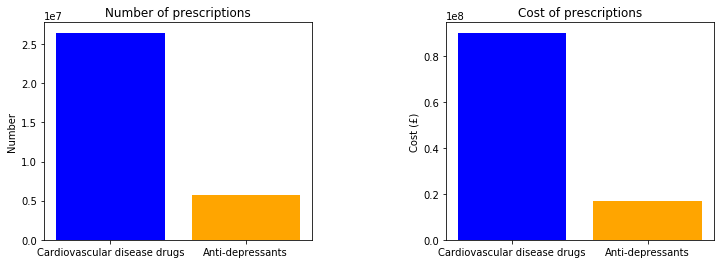

In [822]:
#Plot this information to show it visually
fig = plt.figure(figsize=(12,4))
plt1 = fig.add_subplot(121)
plt2 = fig.add_subplot(122)

# plotting points on each subplot
plt1.bar(prescriptions.index, prescriptions['num_prescriptions'],color=['blue','orange'])
plt1.set_title('Number of prescriptions')
plt1.set_ylabel('Number')
 
plt2.bar(prescriptions.index, prescriptions['cost'],color=['blue','orange'])
plt2.set_title('Cost of prescriptions')
plt2.set_ylabel('Cost (£)')

# adjusting space between subplots
fig.subplots_adjust(hspace=.5,wspace=0.5)

plt.show()
plt.close()

## Question 4
I will now look at total spending and the relatives cost per patient across all practices in England.  First I will create a data frame with the total actual cost and number of registered patients per practice, then I will plot the information in a scatter plot.

In [723]:
# Create database of practices and total act_cost
practice_prescribing_df = prescribing_df[['practice_code','act_cost']].groupby('practice_code').sum().reset_index()
#Add column of number of patients
practice_prescribing_df = pd.merge(practice_prescribing_df, registrations_df[['practice_code','number_of_patients']],\
                                   on='practice_code')
practice_prescribing_df.head()

,practice_code,act_cost,number_of_patients
0,A81001,52194.63,4086
1,A81002,268607.26,19906
2,A81004,139115.40,10165
3,A81005,102914.06,8016
4,A81006,183226.79,14497


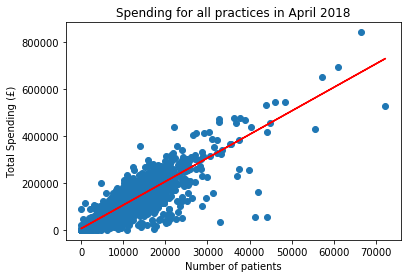

In [726]:
#Set x and y values
x = practice_prescribing_df['number_of_patients']
y = practice_prescribing_df['act_cost']
#create a plot
plt.scatter(x,y)
#label the plot
plt.title('Spending for all practices in April 2018')
plt.xlabel('Number of patients')
plt.ylabel('Total Spending (£)')
#add a trend line
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.show()

There is a positive association between number of patients and total spending at a GP practice.  Most practices have less than 300,000 people and spend less than £400,000/month.  There is considerable spread of practices around the trend line.  Next I will calculate the relative spending (ie. spending per patient) and plot this.

In [730]:
#Calculate relative spending
practice_prescribing_df['relative_spending']= practice_prescribing_df['act_cost']/\
practice_prescribing_df['number_of_patients']

#Look at some secriptive stats
practice_prescribing_df.describe()

,act_cost,number_of_patients,relative_spending
count,7191.000000,7191.000000,7191.000000
mean,87842.769907,8207.557224,11.606497
std,59133.286587,5161.846053,38.868946
min,3.250000,3.000000,0.001724
25%,45118.630000,4557.000000,8.875578
50%,76206.840000,7278.000000,10.914659
75%,117871.110000,10742.500000,12.690038
max,842838.180000,72227.000000,2830.020000


There are some extreme outliers which will distort the data, so I have decided to remove the top and bottom 0.05% of GP practices for spending per patients, leaving practices with £1 - £21/patient

In [762]:
#remove outliers
min_x = math.floor(practice_prescribing_df['relative_spending'].quantile(.005))
max_x = math.floor(practice_prescribing_df['relative_spending'].quantile(.995))
practice_prescribing_limited = practice_prescribing_df[practice_prescribing_df['relative_spending'].between(min_x,max_x)]
min_x,max_x

(1, 21)

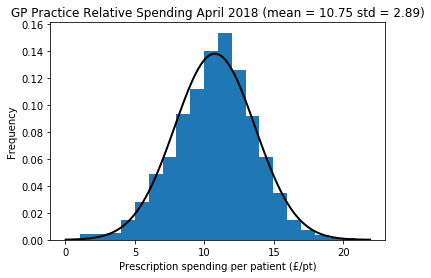

In [770]:
# Use the data without extreme outliers
data = practice_prescribing_limited['relative_spending']

# Calculate mean and standard deviation for the data
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=20, density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("GP Practice Relative Spending April 2018 (mean = %.2f std = %.2f)" % (mu, std))
plt.xlabel("Prescription spending per patient (£/pt)")
plt.ylabel("Frequency")

plt.show()

Spending per patients is normally distributed amongst GP Practices.  In order to target efforts to make efficiency savings, GP practices who have both high total expenditure and high spending per patient can be identified.

## Assignment B

#### Introduction
In this section of the analysis I will be using data from the World Health Organization (avaliable <a href ='https://www.who.int/healthinfo/statistics/mortality_rawdata/en/'>here</a>.  I will be using the same standard modules as in the previous analysis.  I will start by loading the data and inspecting it.

In [217]:
#Load WHO dataframes
pop_df = pd.read_csv('https://www.who.int/healthinfo/Pop.zip?ua=1', compression='zip', index_col=False, \
                     na_values=["NaN"])
mort_df = pd.read_csv('https://www.who.int/healthinfo/statistics/Morticd10_part1.zip?ua=1',compression='zip',\
                      na_values=["NaN"],low_memory=False)
mort_df = mort_df.append(pd.read_csv('https://www.who.int/healthinfo/statistics/Morticd10_part2.zip?ua=1',compression='zip',\
                       na_values=["NaN"],low_memory=False))
country_codes_df = pd.read_csv('https://www.who.int/healthinfo/statistics/country_codes.zip?ua=1',compression='zip')

In [220]:
#Inspect data frames
pop_df.head()

,Country,Admin1,SubDiv,Year,Sex,Frmat,Pop1,Pop2,Pop3,Pop4,...,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26,Lb
0,1060,NaN,NaN,1980,1,7,137100.0,3400.0,15800.0,NaN,...,NaN,5300.0,NaN,2900.0,NaN,NaN,NaN,NaN,6500.0,5000.0
1,1060,NaN,NaN,1980,2,7,159000.0,4000.0,18400.0,NaN,...,NaN,6200.0,NaN,3400.0,NaN,NaN,NaN,NaN,7500.0,6000.0
2,1125,NaN,NaN,1955,1,2,5051500.0,150300.0,543400.0,NaN,...,110200.0,51100.0,41600.0,14300.0,11800.0,25300.0,NaN,NaN,0.0,253329.0
3,1125,NaN,NaN,1955,2,2,5049400.0,145200.0,551000.0,NaN,...,122100.0,51100.0,50700.0,15800.0,18000.0,28500.0,NaN,NaN,0.0,237901.0
4,1125,NaN,NaN,1956,1,2,5353700.0,158700.0,576600.0,NaN,...,116900.0,54100.0,44000.0,14900.0,12400.0,26600.0,NaN,NaN,0.0,250022.0


In [221]:
mort_df.head()

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,1400,NaN,NaN,2001,101,1000,1,7,8,332,...,95.0,NaN,NaN,NaN,NaN,0.0,8.0,NaN,NaN,NaN
1,1400,NaN,NaN,2001,101,1000,2,7,8,222,...,112.0,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,NaN
2,1400,NaN,NaN,2001,101,1001,1,7,8,24,...,5.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,1400,NaN,NaN,2001,101,1001,2,7,8,14,...,6.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,1400,NaN,NaN,2001,101,1002,1,7,8,0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


Population and Mortality dataframes contain data for population and mortality, stratified by Country, Year, Cause and Gender.  Figures are given across all ages (Pop1 and Deaths1), as well as in separate age groups:
- Group2-6 are 1 year age brackets from 'age 0 year' to 'age 5 years'
- Group7-24 are 5 year age brackets from 'age 5-9 years' to 'age 90-94 years'
- Group25 are 'age 95 years and above'
- Group26 are 'age unspecified'

There is also information for live births and further information on infant mortality at age 0.

Countries are identified by a code, and so the final dataframe can identify the code from the country name

In [224]:
country_codes_df.columns = ['Country','Name']
country_codes_df.head()

,Country,Name
0,1010,Algeria
1,1020,Angola
2,1025,Benin
3,1030,Botswana
4,1035,Burkina Faso


### Question 1
I will first look at some population and death data for Iceland, Italy and New Zealand.  I will define some functions to extract the information I need in a table.

In [228]:
#define a function that will return a subset of the country codes data frame for any number of countries
def country_code(*args):
    """Function to return list of country codes. arguments = list of countries as strings"""
    global country_codes_df
#   convert arguments to a list of countries (with standardized capitalisation)
    countries = [a.title() for a in args]
    return country_codes_df[country_codes_df['Name'].isin(countries)]

In [229]:
#define a function that will return a subset of population or mortality data frame for a year
def year_totals(year,df):
    """parameters: year=int, df=pop_df or mort_df, return: dateset filtered by year and grouped by Country"""
    #must be grouped as dataset contains separate rows for males and females
    return df[df['Year']==year].groupby('Country').sum().reset_index()
    

In [233]:
#create dataframe mapping Iceland,Italy and New Zealand to their country codes
q1_countries = country_code('Iceland','Italy','New Zealand')

#create a dataframes of all countries population and mortality for 2010
pop_2010 = year_totals(2010, pop_df)[['Country','Pop1']]
mort_2010 = year_totals(2010, mort_df)[['Country','Deaths1']]

#merge dataframes left join on only the countries we are interested in
q1_countries_2010 = pd.merge(q1_countries, pop_2010, on='Country')
q1_countries_2010 = pd.merge(q1_countries_2010, mort_2010, on='Country')
q1_countries_2010.rename(columns = {'Pop1':'Total_Population','Deaths1':'Total_Deaths'}, inplace = True)

In [779]:
q1_countries_2010

,Country,Name,Total_Population,Total_Deaths
0,4160,Iceland,318041.0,4038
1,4180,Italy,60483386.0,1169230
2,5150,New Zealand,4367360.0,57298


Italy had the largest population of these 3 countries in 2010 at 60.5 million.  New Zealand has 4.37 million and Iceland 318,000.  The total number of deaths are in the same order: 1.17 million in Italy, 57,300 in New Zealand and 4040 in Iceland. (Answers given to 3 significant figures).

### Question 2
I will now focus on Italy, and look at the mortality data stratified by age group. Data will be combined for all causes, years and genders.

In [780]:
#create a subset of mortality data frame for italy
italy_mort_df = mort_df[mort_df['Country'] == 4180]

#create a series of totals for each age group
italy_ages_mortality = italy_mort_df.iloc[:,10:34].sum()

In [781]:
#create list of descriptions of content for Deaths2-25
age_groups = ['Deaths at age 0 year',
              'Deaths at age 1 year',
              'Deaths at age 2 years',
              'Deaths at age 3 years',
              'Deaths at age 4 years',
              'Deaths at age 5-9 years',
              'Deaths at age 10-14 years',
              'Deaths at age 15-19 years',
              'Deaths at age 20-24 years',        
              'Deaths at age 25-29 years',
              'Deaths at age 30-34 years',          
              'Deaths at age 35-39 years',
              'Deaths at age 40-44 years',
              'Deaths at age 45-49 years',          
              'Deaths at age 50-54 years',
              'Deaths at age 55-59 years',         
              'Deaths at age 60-64 years',
              'Deaths at age 65-69 years',  
              'Deaths at age 70-74 years',
              'Deaths at age 75-79 years',  
              'Deaths at age 80-84 years',
              'Deaths at age 85-89 years',           
              'Deaths at age 90-94 years',
              'Deaths at age 95 years and above '
             ]

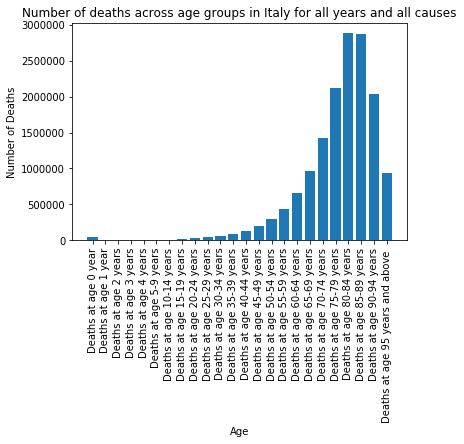

In [268]:
#Plot a bar chart of the number of deaths
plt.bar(age_groups,italy_ages_mortality.values)
plt.xticks(age_groups, rotation='vertical')
plt.xlabel('Age')
plt.ylabel('Number of Deaths')
plt.title('Number of deaths across age groups in Italy for all years and all causes')
plt.show()

The histogram gives a good visualization of the number of deaths increasing exponentially up to age 80-84.  After this point, the total number of deaths per age group decreases (since there are fewer people left at this age).  There is also a small but notable number of infant deaths at age 0 year.

### Question 3
I will now look in more detail at causes of death in Italy, specifically for *Neoplasms*.  ICD-10 codes C00 to D48 cover neoplasms.  In the mortality data set, these are sometimes coded with a condensed code (1026-1047), so I should search for both.

In [793]:
#Create a subset of the Italy mortality database for cancer
italy_neoplasms = italy_mort_df[(italy_mort_df['Cause'].between('C00','D48'))|\
                               (italy_mort_df['Cause'].between('1026','1047'))]

#Group data by 'Cause' for all years and sexes.  Sum remaining columns, show total deaths as 'Deaths1'
italy_neoplasms = italy_neoplasms.groupby('Cause').sum()[['Deaths1']]
italy_neoplasms.columns = ['Total Deaths']

#Calculate the total number of deaths due to neoplasms
total_neoplasm_deaths = italy_neoplasms['Total Deaths'].sum()

#Create a new column: proportion of deaths (%)
italy_neoplasms['Proportion'] = italy_neoplasms['Total Deaths']/total_neoplasm_deaths*100

#Sort the dataset
italy_neoplasms = italy_neoplasms.sort_values(by=['Total Deaths'], ascending=False)

#Create a dataset of the top 5
italy_neoplasms_top5 = italy_neoplasms.iloc[0:5]
italy_neoplasms_top5

,Total Deaths,Proportion
Cause,,
C349,426451,19.041893
C509,155895,6.961025
C189,143188,6.393632
C169,125679,5.611820
C259,120070,5.361366


In [789]:
# Create a dictionary of the causes
neoplasm_dict = {'C349': 'Malignant neoplasm: Bronchus or lung, unspecified',
                 'C509': 'Malignant neoplasm: Breast, unspecified ',
                 'C189': 'Malignant neoplasm: Colon, unspecified',
                 'C169': 'Malignant neoplasm of Stomach, unspecified',
                 'C259': 'Malignant neoplasm: Pancreas, unspecified  '}

In [796]:
#Create a data set for the remaining causes - group as 'Other'
other_neoplasms = italy_neoplasms.iloc[5:].reset_index()
other_neoplasms['Cause'] = 'Other'
other_neoplasms = other_neoplasms.groupby('Cause').sum()

In [794]:
#Add other to the top 5 causes
italy_neoplasms_top5 = italy_neoplasms_top5.append(other_neoplasms)
italy_neoplasms_top5.rename(index=neoplasm_dict, inplace=True)

Text(0.5, 1.0, 'Top causes of death in Italy (all years) for neoplasms')

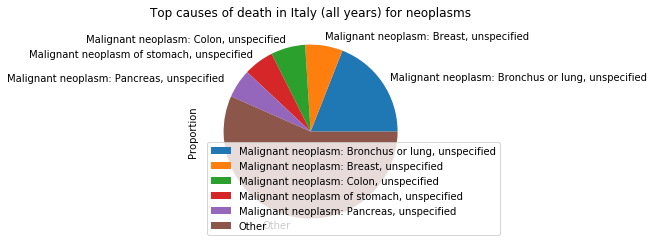

In [797]:
#Create a pie chart of the top causes of death for neoplasms
ax = italy_neoplasms_top5.plot.pie('Proportion')
ax.set_title('Top causes of death in Italy (all years) for neoplasms')

## Question 4
I will now switch to looking at Australia, and identify the top five age groups dying with a *Neoplasms* cause of death.

In [308]:
#Find country code for australia
aus = country_code('Australia')
aus

,Country,Name
211,5020,Australia


In [472]:
#Create a subset of the mortality dataset for 2010
all_mort_2010 = mort_df[mort_df['Year'] == 2010]

#Create criteria for neoplasms (coded with ICD-10 or condensed WHO code)
criteria1 = all_mort_2010['Cause'].between('1026','1047')
criteria2 = all_mort_2010['Cause'].between('C00','D48')

#Create a subset of mortality 2010 for neoplasms
neoplasms_2010 = all_mort_2010[criteria1 | criteria2]

#Create a subset for Australia
aus_neoplasms = neoplasms_2010[neoplasms_2010['Country']==5020]
aus_neoplasms.head()

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
2259359,5020,NaN,NaN,2010,104,C001,1,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259360,5020,NaN,NaN,2010,104,C001,2,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259361,5020,NaN,NaN,2010,104,C009,1,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259362,5020,NaN,NaN,2010,104,C009,2,0,1,5,...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2259363,5020,NaN,NaN,2010,104,C01,1,0,1,20,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [473]:
#Create a series with the total deaths from neoplasm in Australia 2010 for each age group
aus_neoplasms_grouped = aus_neoplasms.iloc[:,10:34].sum()

#Rename the index column with descriptive labels
aus_neoplasms_grouped.index = age_groups

#Sort the groups to identify top 5 age groups in Australia dying with a Neoplasms cause of death
print("Top 5 age groups for death from Neoplasms in Australia 2010:")
aus_neoplasms_grouped.sort_values(ascending=False)[0:5]

Top 5 age groups for death from Neoplasms in Australia 2010:


Deaths at age 80-84 years    7165.0
Deaths at age 75-79 years    6281.0
Deaths at age 70-74 years    5709.0
Deaths at age 85-89 years    5512.0
Deaths at age 65-69 years    4765.0
dtype: float64

Death from *Neoplasms* was most common in 80-84 year olds in Australia in 2010.  The other top 5 age groups are all older people (75-79 year, 70-74 years, 85-89 years and 65-69 years).  This is similar to the distribution of deaths by all causes in Italy that I looked at in Question 2.

## Question 5
Finally, I will compare and contrast the frequency of deaths by *Neoplasms* in Italy and Australia in 2010.

In [474]:
#Create a dataframe to compare 
q5_countries = country_code('Italy','Australia')

#Merge with population from population 2010 data frame
q5_countries = q5_countries.merge(pop_2010, on='Country')

#Create dataframe with total neoplasms for each country
neoplasms_grouped = neoplasms_2010.groupby('Country').sum().reset_index()[['Country','Deaths1']]

#Add deaths from neoplasms to countries dataset
q5_countries = q5_countries.merge(neoplasms_grouped, on='Country')

#Calculate crude death rate
q5_countries['Death Rate (per 100,000 of population)'] = q5_countries['Deaths1']/q5_countries['Pop1']*100000
q5_countries.rename(columns={'Pop1':'Population', 'Deaths1':'Total Deaths'})

,Country,Name,Population,Total Deaths,"Death Rate (per 100,000 of population)"
0,4180,Italy,60483386.0,174405,288.351912
1,5020,Australia,22297515.0,43276,194.084408


Text(0.5, 0, 'Country')

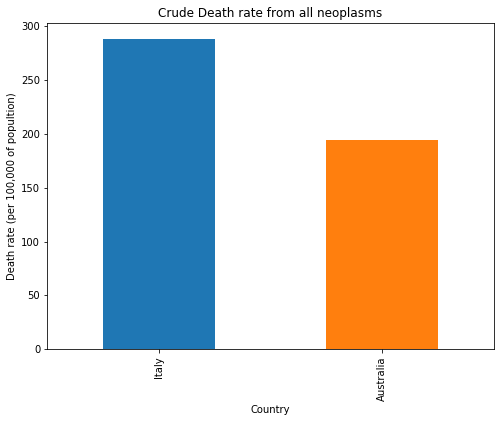

In [808]:
ax1 = q5_countries.plot.bar(x='Name', y='Death Rate (per 100,000 of population)',figsize=(8,6),legend=False)
ax1.set_title('Crude Death rate from all neoplasms')
ax1.set_ylabel('Death rate (per 100,000 of popultion)')
ax1.set_xlabel('Country')

<p>Italy had a higher total number deaths by Neoplasm than Australia in 2010 (174,405 compared to 43,276).</p>
<p>However, the population of Italy is nearly three times the population of Australia, so death rate is a more meaningful statistic.  Calculating death rate (expressed as deaths per 100,000 of the population) shows that Italy has a higher death rate than Australia (288 compared to 194).</p>
<p>We have observed in Question 4 that death by Neoplasm is more common in older people.  Therefor, Italy's higher death rate may be due to having an older population.  In order to fairly compare death rates between countries, it is common to standardize the population age structure.  I will do this now.

In [809]:
#Create a new data frame for Italy and Australia in order to calculate age-standarized death rates
q5_countries_2 = country_code('italy','australia')

#Generate dataframe for population and deaths for all age groups
pop_2010_2 = year_totals(2010,pop_df)
deaths_2010_2 = neoplasms_2010.groupby('Country').sum().reset_index()

#Select Country, Year and Age groups 2-25 
col_selection = ['Country','Year']
pop_selection = ['Pop'+str(x) for x in range(1,26)]
deaths_selection = ['Deaths'+str(x) for x in range(1,26)]

#merge to create dataset with column for population and death for each age group
q5_countries_2 = q5_countries_2.merge(pop_2010_2[col_selection + pop_selection], on='Country')
q5_countries_2 = q5_countries_2.merge(deaths_2010_2[['Country'] + deaths_selection], on='Country')

#Create columns for Age-specific Rates
for i in range(2,26):
    i=str(i)
    q5_countries_2['Rate'+i] = q5_countries_2['Deaths'+i]/q5_countries_2['Pop'+i]
q5_countries_2

,Country,Name,Year,Pop1,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,...,Rate16,Rate17,Rate18,Rate19,Rate20,Rate21,Rate22,Rate23,Rate24,Rate25
0,4180,Italy,4020,60483386.0,559179.0,571110.0,573359.0,571598.0,570307.0,2838221.0,...,0.001386,0.002298,0.003731,0.005746,0.008209,0.011765,0.016420,0.020414,0.022993,0.021794
1,5020,Australia,4020,22297515.0,289368.0,297513.0,294321.0,286030.0,282736.0,1365354.0,...,0.001196,0.002031,0.003251,0.005247,0.008040,0.011357,0.016287,0.020774,0.023344,0.025022


In [810]:
#Create standardised populations for age group based on the mean between italy and australia
age_standard = q5_countries_2.groupby('Year').mean().reset_index()[col_selection+pop_selection]
age_standard

,Country,Year,Pop1,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,Pop8,...,Pop16,Pop17,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25
0,4600.0,4020,41390450.5,424273.5,434311.5,433840.0,428814.0,426521.5,2101787.5,2107819.0,...,2781540.5,2520617.5,2484349.0,2007945.5,1889398.0,1542492.5,1175970.5,712402.0,218889.0,82725.0


In [811]:
#Create Age Standardised Deaths based on age-group death rate and standardized population size
for i in range(2,26):
    i=str(i)
    q5_countries_2['Std_Deaths'+i] = q5_countries_2['Rate'+i] * age_standard.loc[0,'Pop'+i]
q5_countries_2

,Country,Name,Year,Pop1,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,...,Std_Deaths16,Std_Deaths17,Std_Deaths18,Std_Deaths19,Std_Deaths20,Std_Deaths21,Std_Deaths22,Std_Deaths23,Std_Deaths24,Std_Deaths25
0,4180,Italy,4020,60483386.0,559179.0,571110.0,573359.0,571598.0,570307.0,2838221.0,...,3853.906673,5792.082635,9269.596299,11537.703532,15510.487162,18146.769905,19309.702880,14542.628218,5032.943855,1802.909170
1,5020,Australia,4020,22297515.0,289368.0,297513.0,294321.0,286030.0,282736.0,1365354.0,...,3327.473553,5120.341615,8077.476106,10535.237412,15191.243996,17517.738323,19153.571835,14799.699330,5109.848476,2069.968122


In [812]:
#Create column of sum of total standardised deaths for all age groups (columns 77:101)
q5_countries_2['Total_Std_Deaths'] = q5_countries_2[q5_countries_2.columns[77:101]].sum(axis=1)
q5_countries_2[['Name','Deaths1','Total_Std_Deaths']]

,Name,Deaths1,Total_Std_Deaths
0,Italy,174405,109878.655399
1,Australia,43276,105554.303078


In [813]:
#Create column for Age-Standardized death Rate from cancer
q5_countries_2['Std_Rate'] = q5_countries_2['Total_Std_Deaths'] / age_standard.loc[0,'Pop1']*100000
q5_countries_2[['Name','Std_Rate']]

,Name,Std_Rate
0,Italy,265.468614
1,Australia,255.020909


Text(0.5, 0, 'Country')

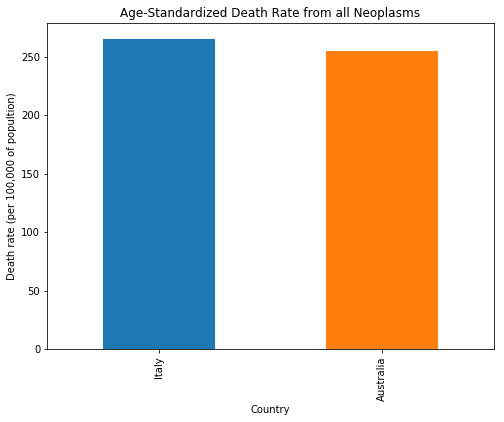

In [814]:
#plot the age-standardized bar chart
ax2 = q5_countries_2.plot.bar(x='Name', y='Std_Rate',figsize=(8,6),legend=False)
ax2.set_title('Age-Standardized Death Rate from all Neoplasms')
ax2.set_ylabel('Death rate (per 100,000 of popultion)')
ax2.set_xlabel('Country')

After standardizing the population age structure (taken as the mean between Australia and Italy), the age-standardized death rate is calculated.  This is the death rate if each country had the same death rate within each age group as is observed, but instead had a standard population structure.  This shows that although Italy still has a slightly higher death rate from Neoplasms, it is not as different as in the crude analysis (265 compared to 255 per 100,000 population).